In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from typing import List, Tuple

from dateutil.relativedelta import relativedelta

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

Загрузим данные о почасовом потреблении электрической энергии и температуре окружающего воздуха, построим визуализации и исследуем данные на наличие различных зависимостей.

In [55]:
df = pd.read_csv('data_for_train/clean_hour_data.csv')
df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M:%S')
df.set_index('datetime', inplace=True)
print('df.shape', df.shape)
df.head(2)

df.shape (64992, 2)


,one_hour_consumption,one_hour_temperature
datetime,,
2016-01-01 00:00:00,3962.983333,-8.313333
2016-01-01 01:00:00,3808.266667,-8.260000


In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 64992 entries, 2016-01-01 00:00:00 to 2023-05-31 23:00:00
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   one_hour_consumption  64992 non-null  float64
 1   one_hour_temperature  64992 non-null  float64
dtypes: float64(2)
memory usage: 1.5 MB


Очевидно, что данные такого типа имеют сезонность. Выполним быстрое преобразование Фурье для извлечения наиболее важных частот.

In [57]:
def fast_fourier_transform(data: pd.DataFrame, freq: List[str], y_lim: Tuple[float]) -> None:
    """
    Визуализаия результатов быстрого преобразования Фурье.
    На вход требется колонка датафрема с данными,
    Ожидаемые частоты (выберите из):
    '1/Year'
    '1/Month'
    '1/Week'
    '1/Day'
    Пределы по вертикальной оси (для графика)
    """
    fft = tf.signal.rfft(data)    # преобразование Фурье
    f_per_dataset = np.arange(0, len(fft))

    hours_per_dataset = len(data) # данный код требуется, чтобы привести единичную частоту к одному году
    hours_per_year = 24*365.2524
    years_per_dataset = hours_per_dataset/hours_per_year
    f_per_year = f_per_dataset/years_per_dataset

    _, ax = plt.subplots(figsize=(21, 12))

    ax.step(f_per_year, np.abs(fft) / np.max(np.abs(fft)))

    ax.set_xscale('log')
    ax.set_xlim(0.1, max(plt.xlim()))
    ax.set_xlabel('Частота (логарифмическая шкала)')

    ax.set_ylim(y_lim)
    ax.set_ylabel('Амплитуда')

    values = [1, 12, 52.1789, 365.2524]
    labels = ['1/Year', '1/Month', '1/Week', '1/Day']

    for value, label in zip(values, labels):
        if label in freq:
            ax.annotate(text=label, xy=(value, 0), xytext=(np.log(value), -25), 
                        xycoords='data', textcoords='offset points',
                        arrowprops=dict(arrowstyle='->'))

    ax.set_title(f'График частотных компонент для {data.name.replace("_", " ").title()}')

    plt.show()

    return None

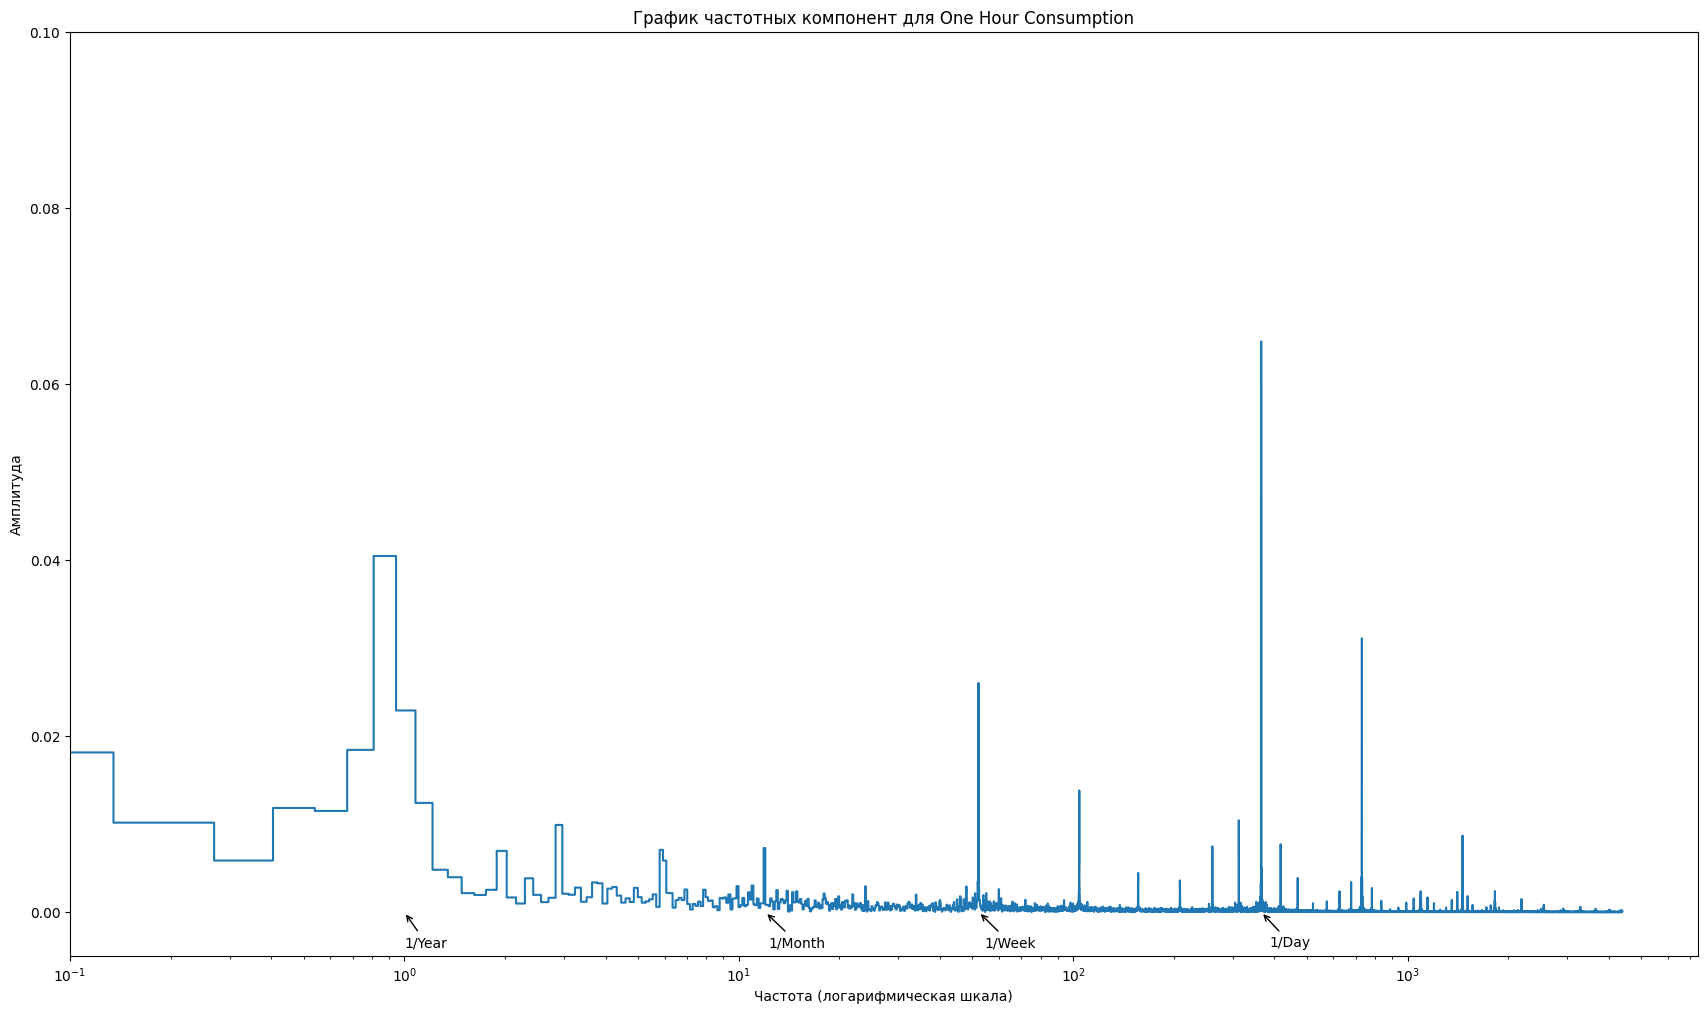

In [58]:
fast_fourier_transform(df['one_hour_consumption'], ['1/Year', '1/Month', '1/Week', '1/Day'], (-0.005, 0.1))

Помимо отмеченных частот для данных о потреблении присутствуют и другие всплески, кратные приведенным (3.5 суток, 12 часов и т.д.), однако практической пользы частоты этих сигналов не имеют.

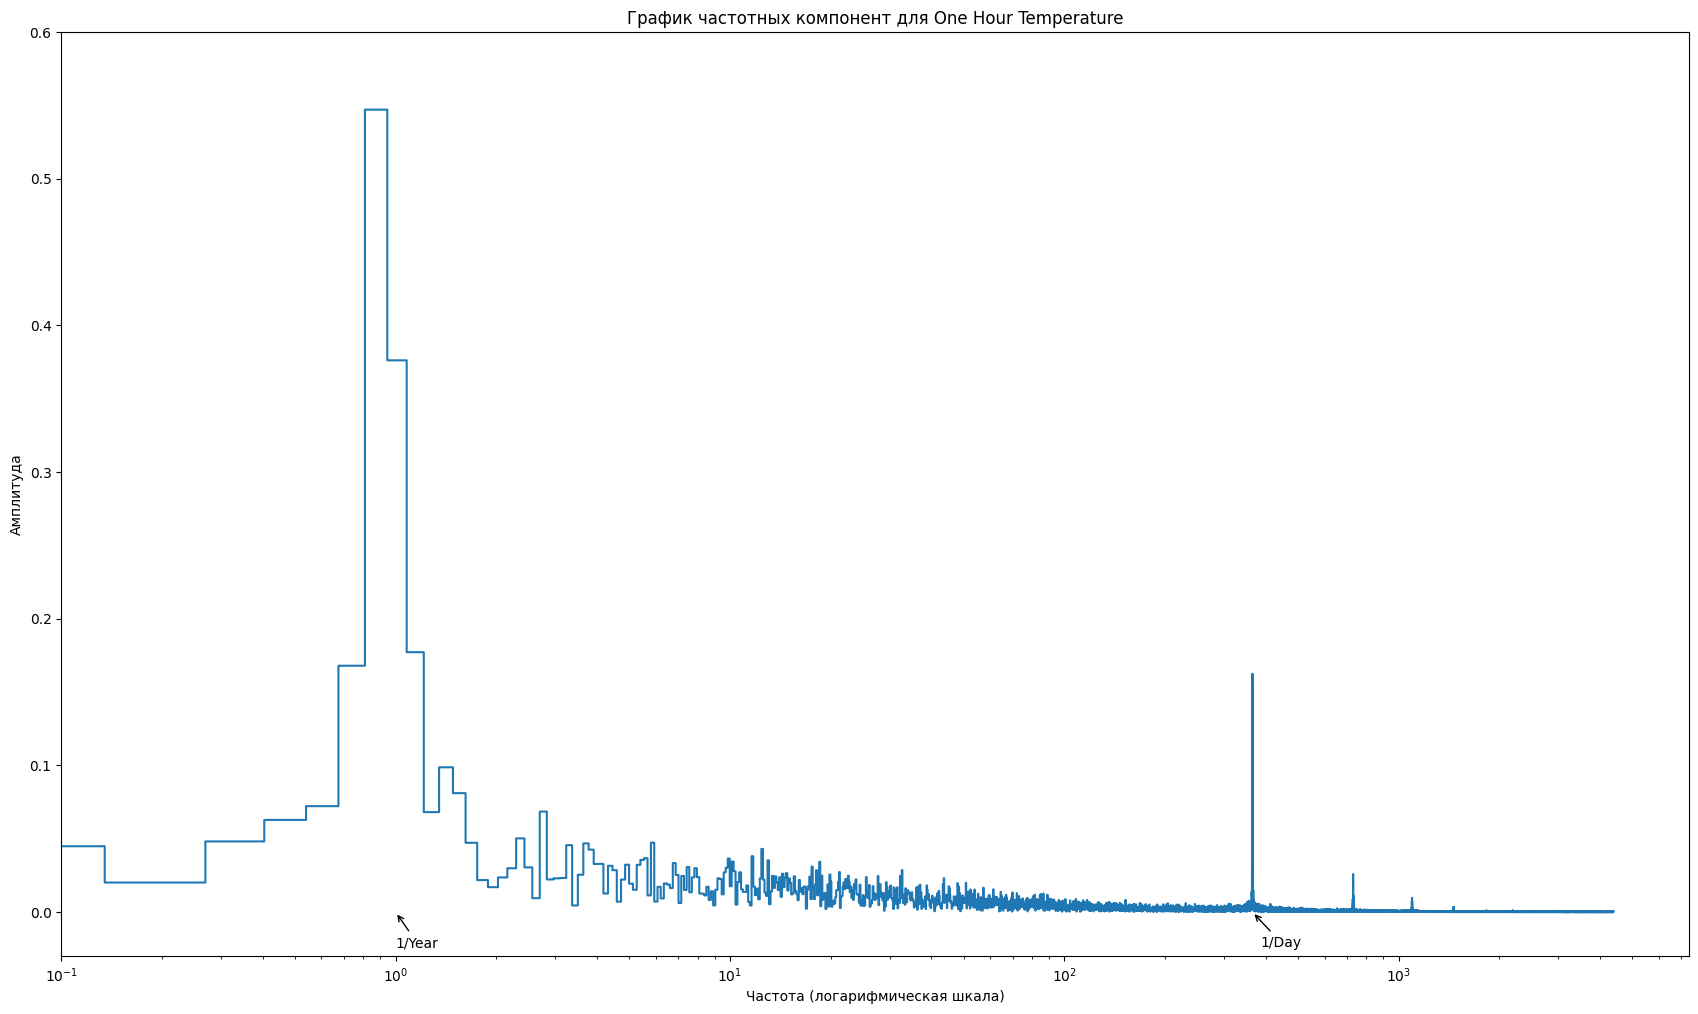

In [59]:
fast_fourier_transform(df['one_hour_temperature'], ['1/Year', '1/Day'], (-0.03, 0.6))

Температура не имеет резонанса на недельной или месячной частоте.

Проверим наши данные на стационраность с помощью расширенного теста Дики-Фуллера. Про проведении данного теста выдвигается гипотеза о наличии единичного корня у характеристического уравнения авторегрессионной модели временного ряда и его нестационарности. Альтернативная гипотеза свидетельстует о стационарности временного ряда. Для корректнсти данных проверим по некоторым частотам: суточной, недельной и месячной.

In [60]:
adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(df['one_hour_consumption'].iloc[-24:])
pvalue

0.590794241971506

In [61]:
adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(df['one_hour_consumption'].iloc[-168:])
pvalue

0.07499997850658104

In [62]:
adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(df['one_hour_consumption'].iloc[-720:])
pvalue

0.18478680895619798

Если предложить тесту Дикки-Фуллера большую подпоследовательность данных, результаты начинают вызвать сомнения и тест показывает наличие стационарности в данных. Всё же попробуем привести датасет к стационарному, вычитая предыдущие значения с наиболее детектируемых частот.

In [63]:
temp_df = pd.concat(
                        [
                            pd.DataFrame(columns=df.columns,
                                         index = pd.date_range(start=df.index[0] - relativedelta(years=1),
                                                               end=df.index[0],
                                                               freq='H')[:-1]),
                            df.copy()
                        ],
                        axis=0
                    )
print('temp_df.shape', temp_df.shape)
temp_df.head(2)

temp_df.shape (73752, 2)


,one_hour_consumption,one_hour_temperature
2015-01-01 00:00:00,NaN,NaN
2015-01-01 01:00:00,NaN,NaN


In [64]:
day_ago_index = tuple(index - relativedelta(days=1) for index in df.index)
week_ago_index = tuple(index - relativedelta(weeks=1) for index in df.index)
month_ago_index = tuple(index - relativedelta(months=1) for index in df.index)
year_ago_index = tuple(index - relativedelta(years=1) for index in df.index)

df['day_ago_consumption'] = temp_df.loc[pd.DatetimeIndex(day_ago_index), 'one_hour_consumption'].values
df['week_ago_consumption'] = temp_df.loc[pd.DatetimeIndex(week_ago_index), 'one_hour_consumption'].values
df['month_ago_consumption'] = temp_df.loc[pd.DatetimeIndex(month_ago_index), 'one_hour_consumption'].values
df['year_ago_consumption'] = temp_df.loc[pd.DatetimeIndex(year_ago_index), 'one_hour_consumption'].values
df.dropna(axis=0, inplace=True)

df['day_ago_consumption_diff'] = df['one_hour_consumption'] - df['day_ago_consumption']
df['week_ago_consumption_diff'] = df['one_hour_consumption'] - df['week_ago_consumption']
df['month_ago_consumption_diff'] = df['one_hour_consumption'] - df['month_ago_consumption']
df['year_ago_consumption_diff'] = df['one_hour_consumption'] - df['year_ago_consumption']

df.drop(['day_ago_consumption',
         'week_ago_consumption',
         'month_ago_consumption',
         'year_ago_consumption'], axis=1, inplace=True)

print('df.shape', df.shape)
df.head(2)

df.shape (56208, 6)


,one_hour_consumption,one_hour_temperature,day_ago_consumption_diff,week_ago_consumption_diff,month_ago_consumption_diff,year_ago_consumption_diff
datetime,,,,,,
2017-01-01 00:00:00,3758.183333,0.0,13.083333,-57.283333,-208.450000,-204.800000
2017-01-01 01:00:00,3622.550000,0.0,68.633333,-14.716667,-190.516667,-185.716667


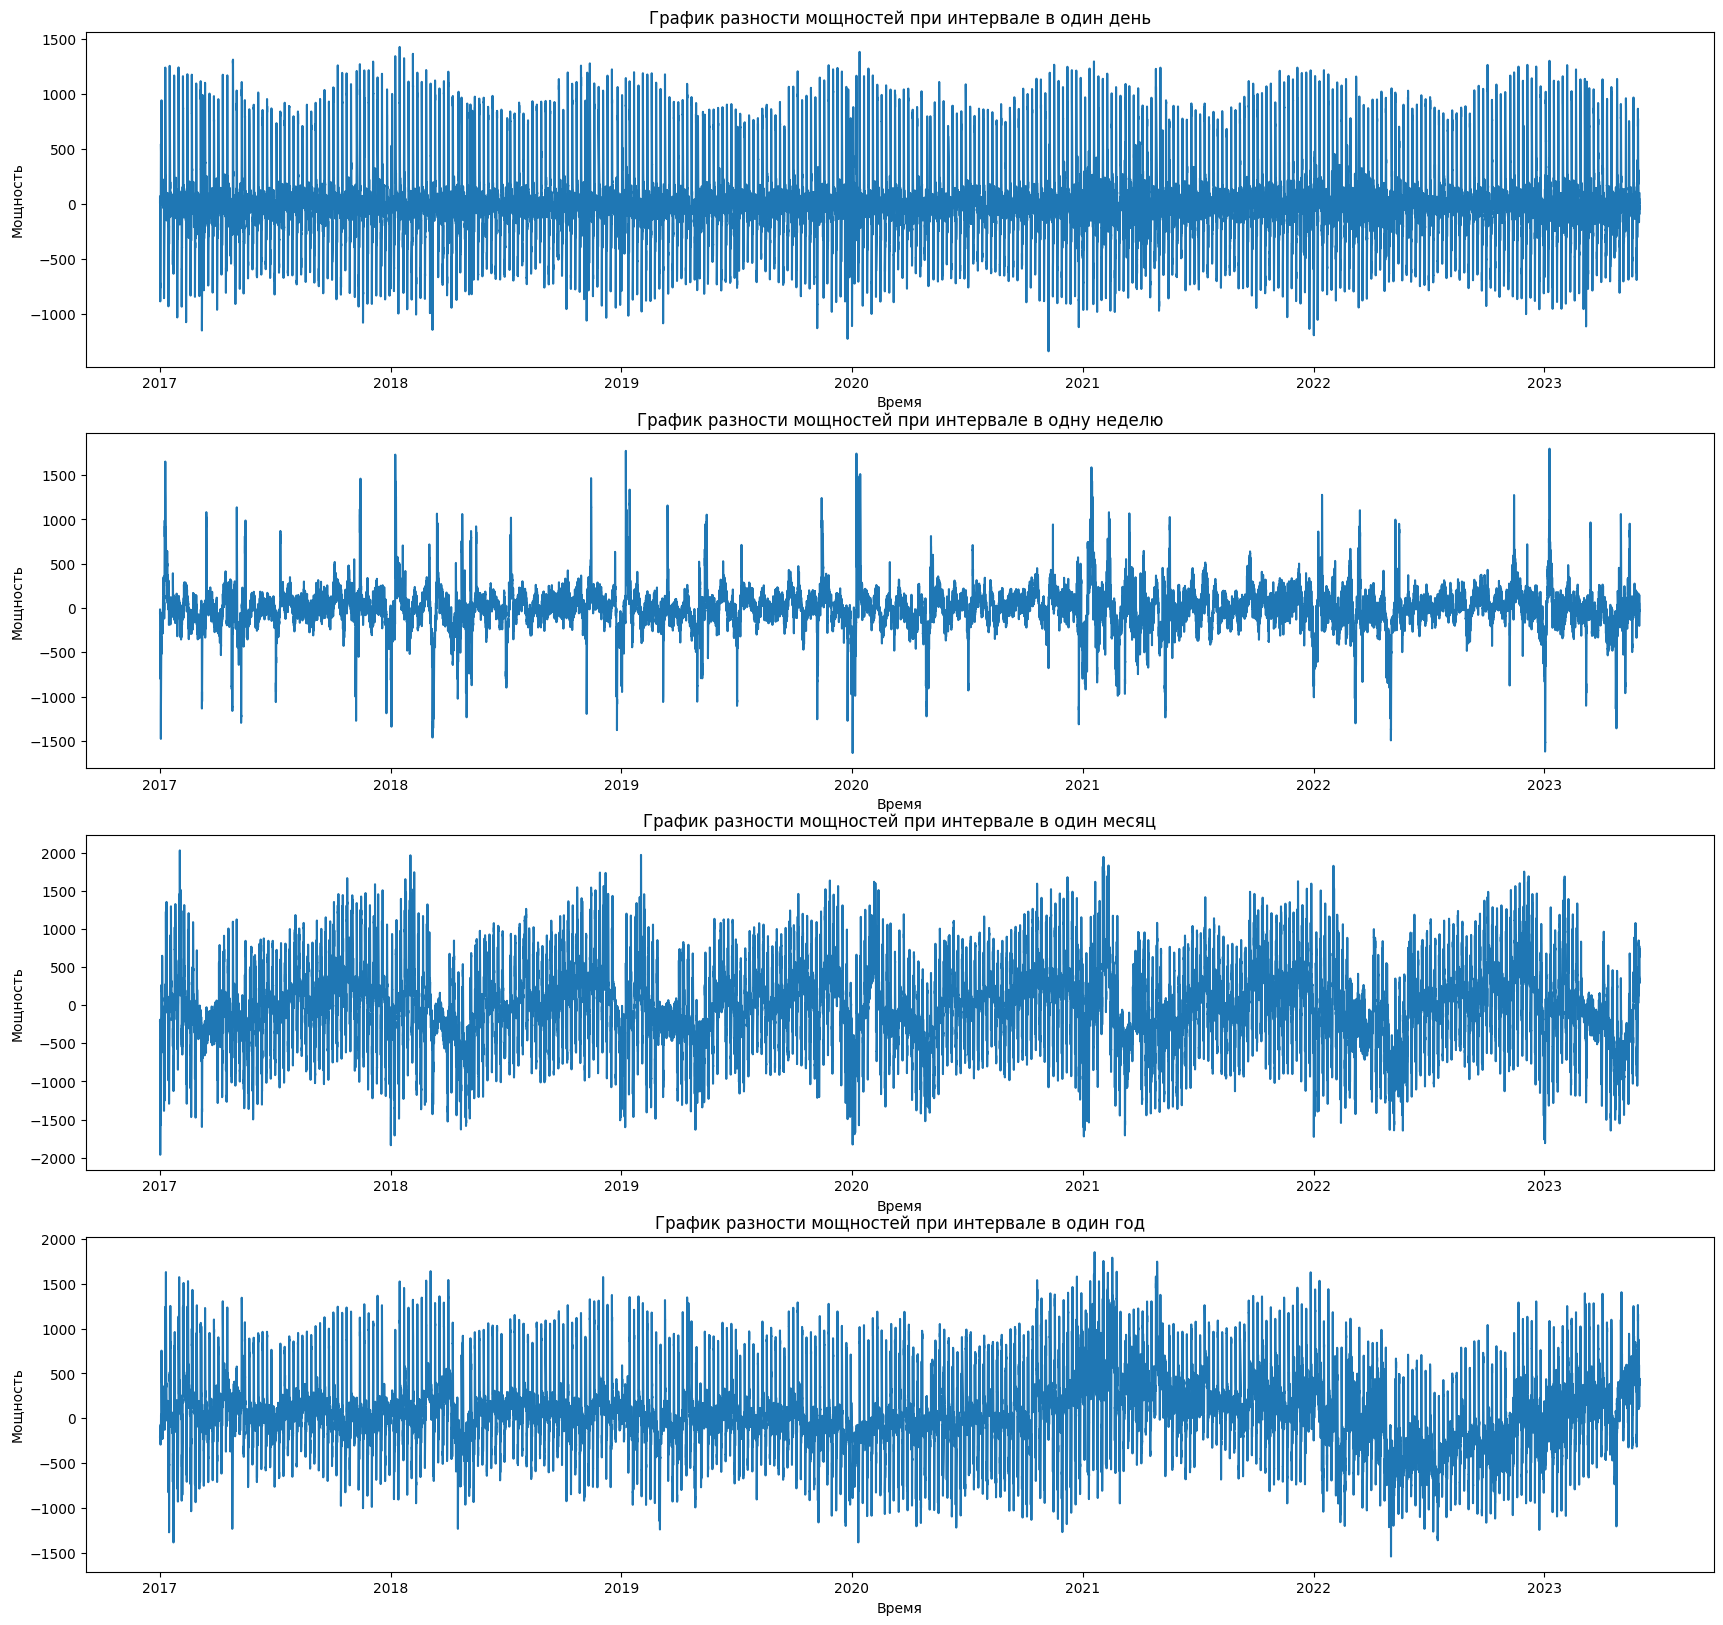

In [65]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, figsize=(21, 20), sharex=False)

ax1.plot(df['day_ago_consumption_diff'])
ax1.set_xlabel('Время')
ax1.set_ylabel('Мощность')
ax1.set_title('График разности мощностей при интервале в один день')

ax2.plot(df['week_ago_consumption_diff'])
ax2.set_xlabel('Время')
ax2.set_ylabel('Мощность')
ax2.set_title('График разности мощностей при интервале в одну неделю')

ax3.plot(df['month_ago_consumption_diff'])
ax3.set_xlabel('Время')
ax3.set_ylabel('Мощность')
ax3.set_title('График разности мощностей при интервале в один месяц')

ax4.plot(df['year_ago_consumption_diff'])
ax4.set_xlabel('Время')
ax4.set_ylabel('Мощность')
ax4.set_title('График разности мощностей при интервале в один год')

plt.show()

Самый интересный результат демонстрирует разность на уровне недели. Проверим для него стационарность с помощью того же теста. Привязываться к стандартным периодам времени не будем.

In [66]:
adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(df['week_ago_consumption_diff'].iloc[-25:])
pvalue

0.8840102045711306

In [67]:
adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(df['week_ago_consumption_diff'].iloc[-50:])
pvalue

0.2690315300125482

In [68]:
adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(df['week_ago_consumption_diff'].iloc[-100:])
pvalue

0.005946624571105482

In [69]:
adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(df['week_ago_consumption_diff'].iloc[-200:])
pvalue

0.0011118361230437316

In [70]:
adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(df['week_ago_consumption_diff'].iloc[-500:])
pvalue

3.911501163154508e-06

Не вполне понятный результат...

In [71]:
df.drop(['day_ago_consumption_diff',
         'week_ago_consumption_diff',
         'month_ago_consumption_diff',
         'year_ago_consumption_diff'], axis=1, inplace=True)

Проведем разложение на тренд и сезонную составляющую с помощью библиотеки statsmodels. Учитывая результаты теста Дикки-Фуллера, я ожидаю увидеть сравнительно малое высокое значение тренда в сравнении с сезонной составляющей. Однако, сезонная состаляющая также будет присутствовать. Больше всего проблем ожидается от нераспределенного остатка.

In [72]:
def decompose_time_series(df: pd.DataFrame, model: str = 'additive'):
    """
    Визуализация разложения на трендовую и сезонную составляющую с помощью библиотеки
    statsmodels.
    На вход требует датафрейм и тип сезонных компонент:
    additive или multiplicative.
    """
    for col, col_values in df.items():
        
        try:
        
            decomposition = seasonal_decompose(x=col_values, model=model)
            print(f'< {col} >'.center(180, '-') + '\n')

            fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, figsize=(15, 12), sharex=True)

            ax1.plot(col_values, color='darkblue')
            ax1.set(title='Original values', xlim=[df.index[0], df.index[-1]])

            ax2.plot(decomposition.trend, color='darkorange')
            ax2.set(title='Trend component')

            ax3.plot(decomposition.seasonal, color='darkgreen')
            ax3.set(title='Seasonal component')

            ax4.scatter(df.index, decomposition.resid, s=10, c='firebrick', alpha=0.5, edgecolor='black', linewidths=0.5)
            ax4.set(title='Residual component')

            fig.tight_layout()
            plt.show()
        
        except ValueError as e:
            print(f'Error: {model} can not decomose {col.replace("_", " ").title()} time series, error: {e}')

------------------------------------------------------------------------------< one_hour_consumption >------------------------------------------------------------------------------



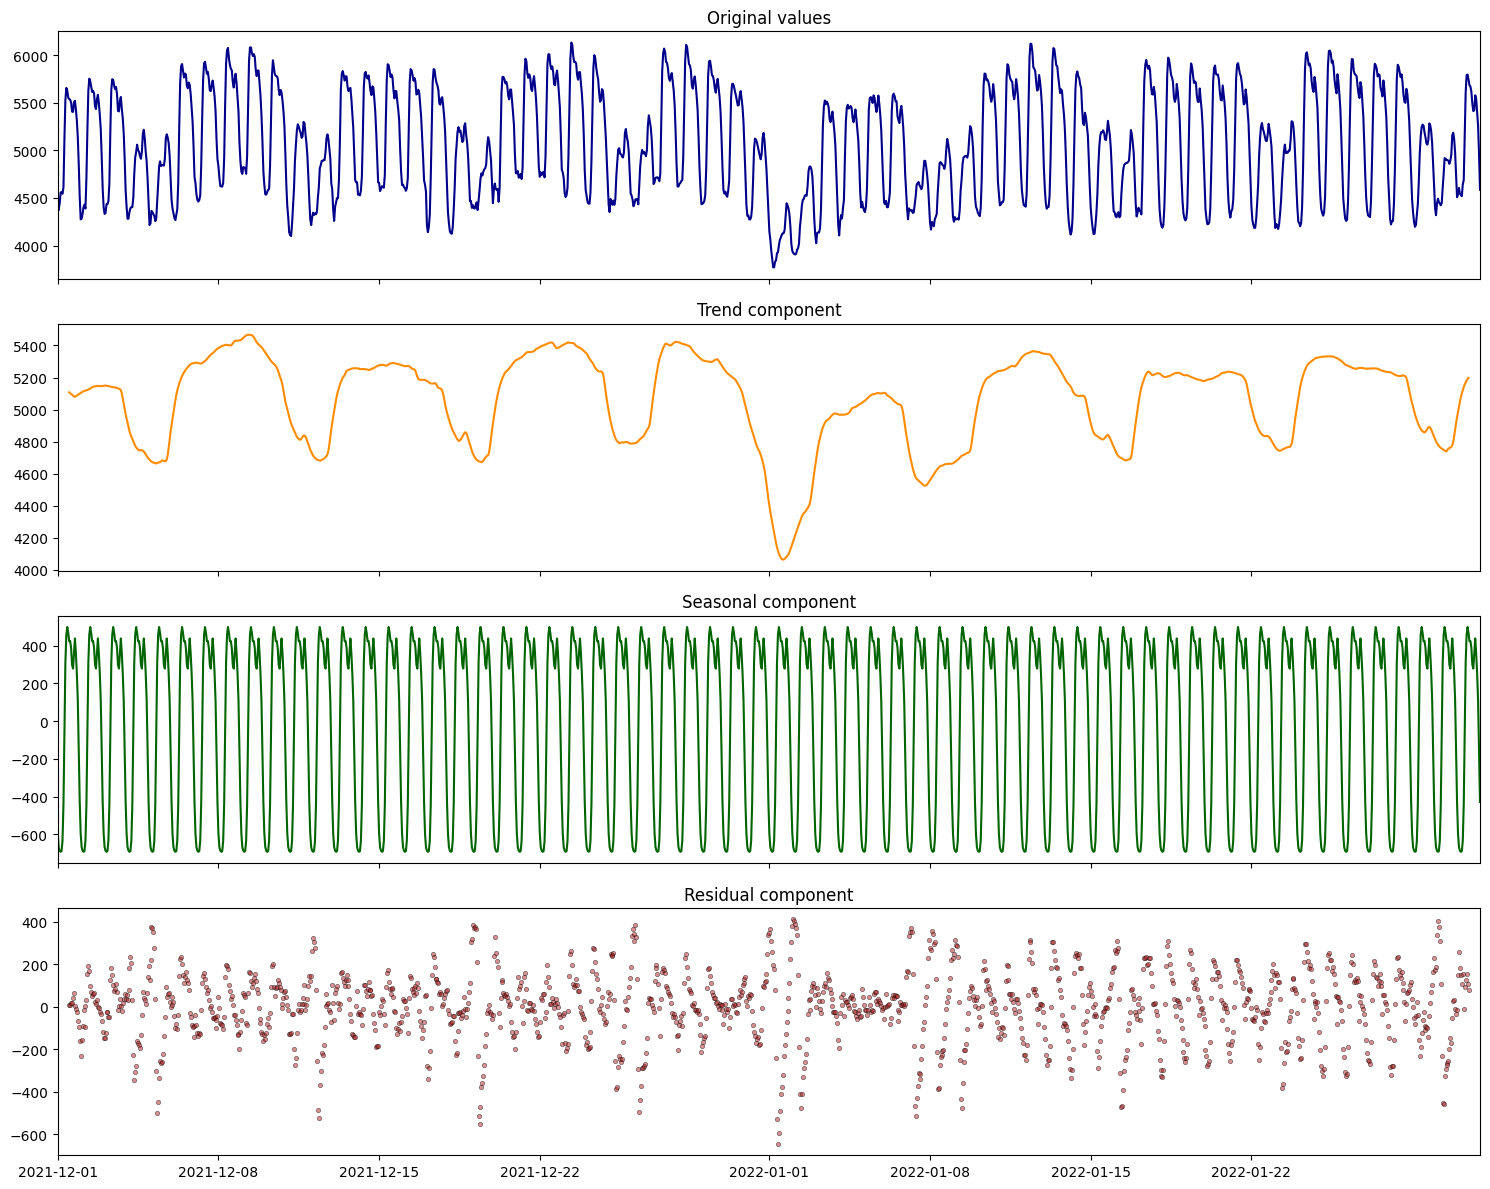

------------------------------------------------------------------------------< one_hour_temperature >------------------------------------------------------------------------------



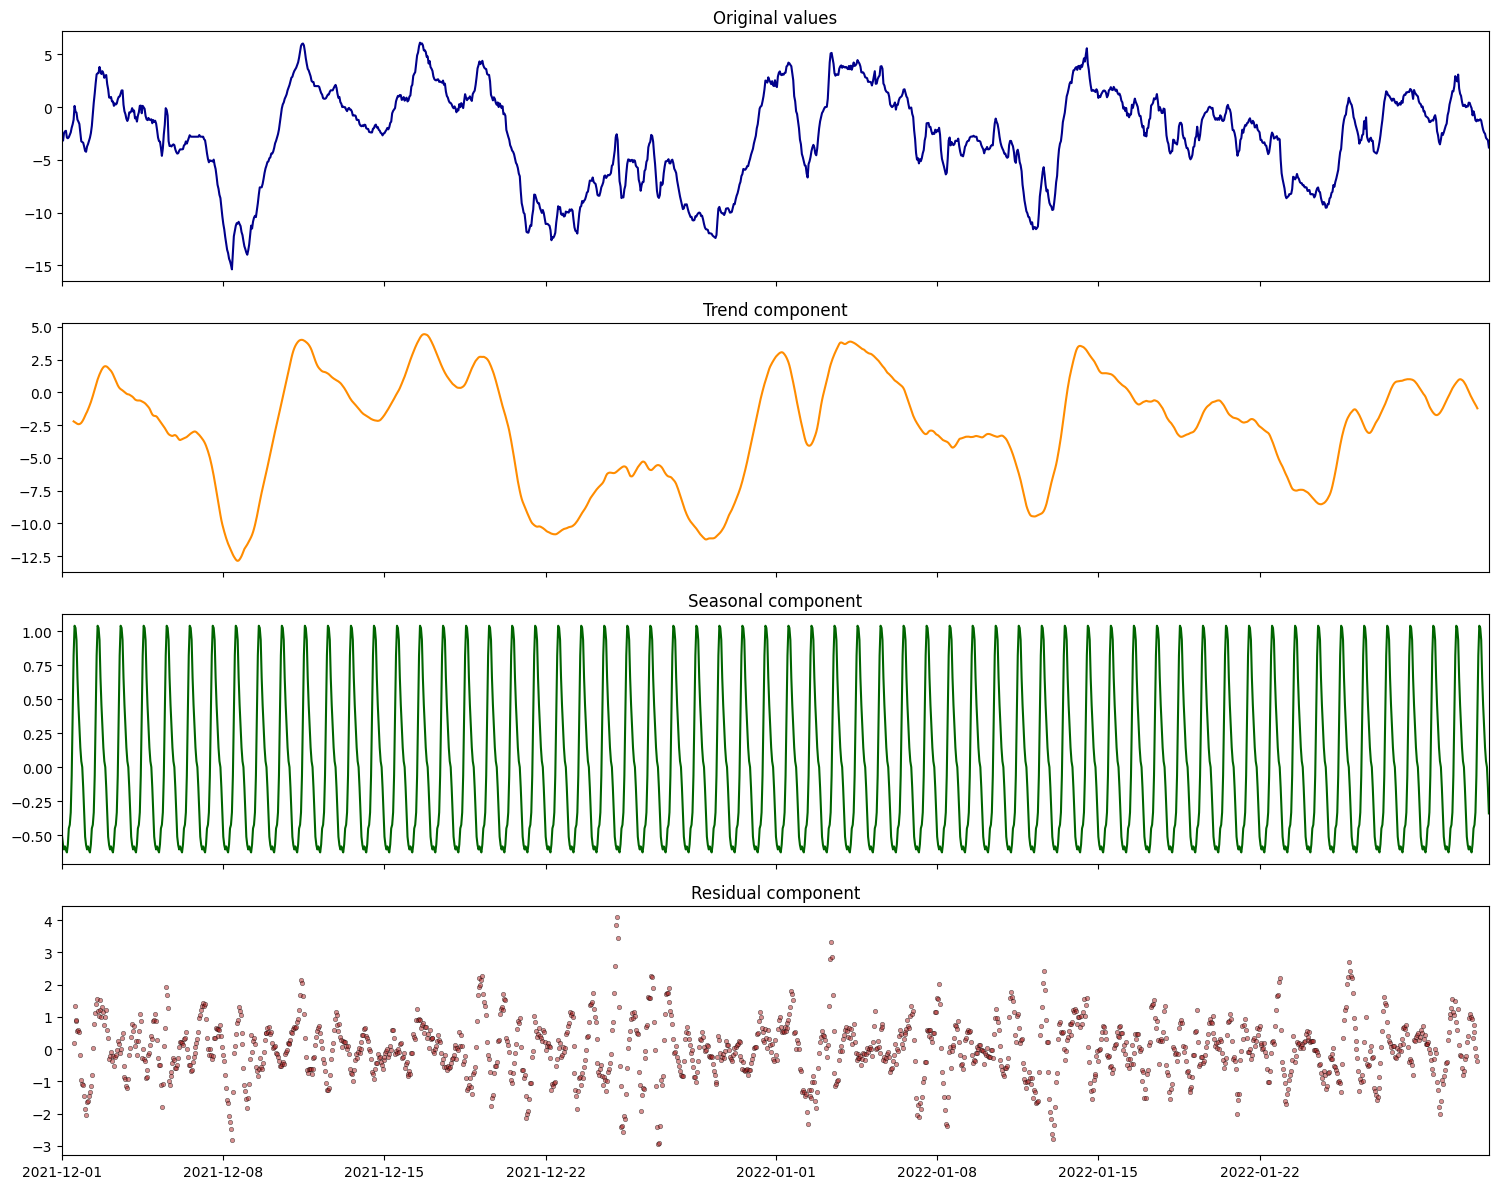

In [73]:
decompose_time_series(df=df.loc['2021-12':'2022-01', :], model='additive')